<p style="font-family: 'Courier New', Courier, monospace; font-size: 50px; font-weight: bold; color: blue;  text-align: center;">
  LoRaWAN Path Loss Measurements in an Indoor Setting: EXPLORATORY DATA ANALYSIS
</p>

<div style="text-align: center;">
    <img src="lorawan.png" alt="LoRaWAN">
    <div style="text-align: right;">Photo Credit: <a href="https://onesight.solutions/wp-content/uploads/2023/10/LoraWAN-Test-Kit-Sales-Tech-Rev-2.pdf">Here</a></div>
</div>


In [3]:
# Libraries/Packages Used:

import os                          # For accessing environment variables.
from dotenv import load_dotenv      # To load environment variables from a .env file.
import pandas as pd                # For data manipulation and analysis.
import numpy as np                 # For numerical computations and handling arrays.
import math                        # For mathematical functions.
from datetime import datetime, timedelta  # For handling date and time operations.
import itertools                   # To cycle through iterables.
from itertools import cycle        # To cycle through specific iterables like colors.
import matplotlib.pyplot as plt    # For creating static visualizations.
from matplotlib.lines import Line2D # For custom lines in plots.
import seaborn as sns              # For statistical data visualization based on matplotlib.
import plotly.graph_objs as go     # For creating interactive visualizations.
from plotly.subplots import make_subplots  # For creating interactive subplots.

In [4]:
# Load environment variables from the .env file
load_dotenv()

# Run the Data_Querying notebook to fetch and prepare the data
# %run "Data_Querying.ipynb"

True

In [5]:
# Read data from a local CSV file
new_df = pd.read_csv('../all_data_files/combined_measurements_data.csv')

# Print the info about the combined DataFrame
print("\nInfo of Combined DataFrame:\n")
new_df.info()


Info of Combined DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81211 entries, 0 to 81210
Data columns (total 71 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   time                                                     81211 non-null  object 
 1   correlation_ids_0                                        81211 non-null  object 
 2   device_id                                                81211 non-null  object 
 3   end_device_ids_application_ids_application_id            81211 non-null  object 
 4   end_device_ids_dev_addr                                  81211 non-null  object 
 5   end_device_ids_dev_eui                                   81211 non-null  object 
 6   end_device_ids_device_id                                 81211 non-null  object 
 7   end_device_ids_join_eui                                  81211 non-null  int64  
 

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Creating the assorted/aggregated measurements Dataframe
</p>

In [7]:
# Columns to keep and their new names for better readability
columns_to_keep = {
    'time': 'time',
    'end_device_ids_device_id': 'device_id',
    'uplink_message_decoded_payload_co2': 'co2',
    'uplink_message_decoded_payload_humidity': 'humidity',
    'uplink_message_decoded_payload_pm25': 'pm25',
    'uplink_message_decoded_payload_pressure': 'pressure',
    'uplink_message_decoded_payload_temperature': 'temperature',
    'uplink_message_rx_metadata_0_rssi': 'rssi',
    'uplink_message_rx_metadata_0_snr': 'snr',
    'uplink_message_settings_data_rate_lora_spreading_factor': 'SF',
    'uplink_message_settings_frequency': 'frequency',
    'uplink_message_f_cnt': 'f_count',
    'uplink_message_decoded_payload_packetCount' : 'p_count',
    'uplink_message_consumed_airtime' : 'toa'
}

# Select and rename columns to keep the dataset clean
cleaned_df = new_df[list(columns_to_keep.keys())].rename(columns=columns_to_keep)

# Add a 'distance' column based on device_id values
distance_map = {
    'pilotdevice'  : 10,
    'pilotdevice01': 8,
    'pilotdevice02': 25,
    'pilotdevice03': 18,
    'pilotdevice04': 39,
    'pilotdevice05': 43
}

# Map the distances to the devices
cleaned_df['distance'] = cleaned_df['device_id'].map(distance_map)

# Define the mapping for c_walls and w_walls
wall_counts_map = {
    'pilotdevice': (0, 0),
    'pilotdevice01': (1, 0),
    'pilotdevice02': (0, 2),
    'pilotdevice03': (1, 2),
    'pilotdevice04': (0, 5),
    'pilotdevice05': (2, 2)
}

# Map the c_walls and w_walls columns using the provided tuple mapping
cleaned_df[['c_walls', 'w_walls']] = cleaned_df['device_id'].map(wall_counts_map).apply(pd.Series)

# Shorten the device names for easier reference
device_name_map = {
    'pilotdevice'  : 'ED0',
    'pilotdevice01': 'ED1',
    'pilotdevice02': 'ED2',
    'pilotdevice03': 'ED3',
    'pilotdevice04': 'ED4',
    'pilotdevice05': 'ED5'
}

# Apply the name mapping so that devices now use shorter names
cleaned_df['device_id'] = cleaned_df['device_id'].map(device_name_map)

# Convert the frequency column to numeric (handling any errors) and convert to MHz
cleaned_df['frequency'] = pd.to_numeric(cleaned_df['frequency'], errors='coerce')
cleaned_df['frequency'] = cleaned_df['frequency'] / 1e6  # Hz to MHz

# Clean up the 'toa' column by removing the 's' at the end and converting to float
cleaned_df['toa'] = cleaned_df['toa'].str.rstrip('s').astype(float)

# Adding the 'experimental_PL' column based on the provided constants and formula
cleaned_df = cleaned_df.assign(
    exp_pl = 14 - 1 + 1.4 + 3 - cleaned_df['rssi']  
    # Using the exact values: tx_p=14, tx_cl=1, tx_ag=1.4, rx_ag=3, tx_cl=0
)

# Calculate Noise Power (n_power) in dBm
cleaned_df = cleaned_df.assign(
    n_power = cleaned_df['rssi'] - 10 * np.log10(np.power(10, cleaned_df['snr'] / 10) + 1)
)

# Calculate Effective Signal Power (esp) in dBm
cleaned_df = cleaned_df.assign(
    esp = cleaned_df['n_power'] + cleaned_df['snr']
)

# Save the cleaned and aggregated data to a CSV file 
cleaned_df.to_csv('aggregated_measurements_data.csv', index=False)

# Display DataFrame information to confirm everything
cleaned_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81211 entries, 0 to 81210
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         81211 non-null  object 
 1   device_id    81211 non-null  object 
 2   co2          81211 non-null  float64
 3   humidity     81211 non-null  float64
 4   pm25         81211 non-null  float64
 5   pressure     81211 non-null  float64
 6   temperature  81211 non-null  float64
 7   rssi         81211 non-null  float64
 8   snr          81089 non-null  float64
 9   SF           81211 non-null  float64
 10  frequency    81211 non-null  float64
 11  f_count      81211 non-null  float64
 12  p_count      81211 non-null  float64
 13  toa          81211 non-null  float64
 14  distance     81211 non-null  int64  
 15  c_walls      81211 non-null  int64  
 16  w_walls      81211 non-null  int64  
 17  exp_pl       81211 non-null  float64
 18  n_power      81089 non-null  float64
 19  esp 

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Channel Usage Transmissions Confirmation / Check
</p>

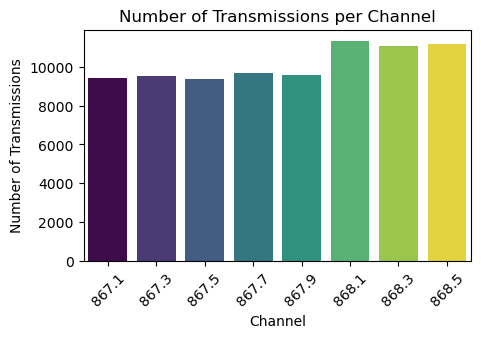

In [9]:
# Count transmissions per channel
channel_counts = cleaned_df['frequency'].value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(5, 3))
sns.barplot(
    x=channel_counts.index,
    y=channel_counts.values,
    hue=channel_counts.index,      # 'x' to 'hue'
    palette='viridis',
    dodge=False,                  
    legend=False              
)
plt.title('Number of Transmissions per Channel')
plt.xlabel('Channel')
plt.ylabel('Number of Transmissions')
plt.xticks(rotation=45)
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Packet Delivery Ratio (PDR)
</p>

In [11]:
# Grouping data by device_id
grouped = cleaned_df.groupby('device_id')

# Calculating the total sent and received packets
pdr_table = grouped.agg(
    total_sent_packets=('p_count', 'max'),
    received_packets=('f_count', 'max')
)

# Calculating the PDR
pdr_table['PDR (%)'] = (pdr_table['received_packets'] / pdr_table['total_sent_packets']) * 100

# Displaying the result as a table
pdr_table


,total_sent_packets,received_packets,PDR (%)
device_id,,,
ED0,35906.0,32123.0,89.464156
ED1,35903.0,32117.0,89.454920
ED2,35908.0,31979.0,89.058149
ED3,35901.0,32055.0,89.287206
ED4,40018.0,35465.0,88.622620
ED5,40030.0,36719.0,91.728703


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Checking Anomalies with BOX PLOTS
</p>

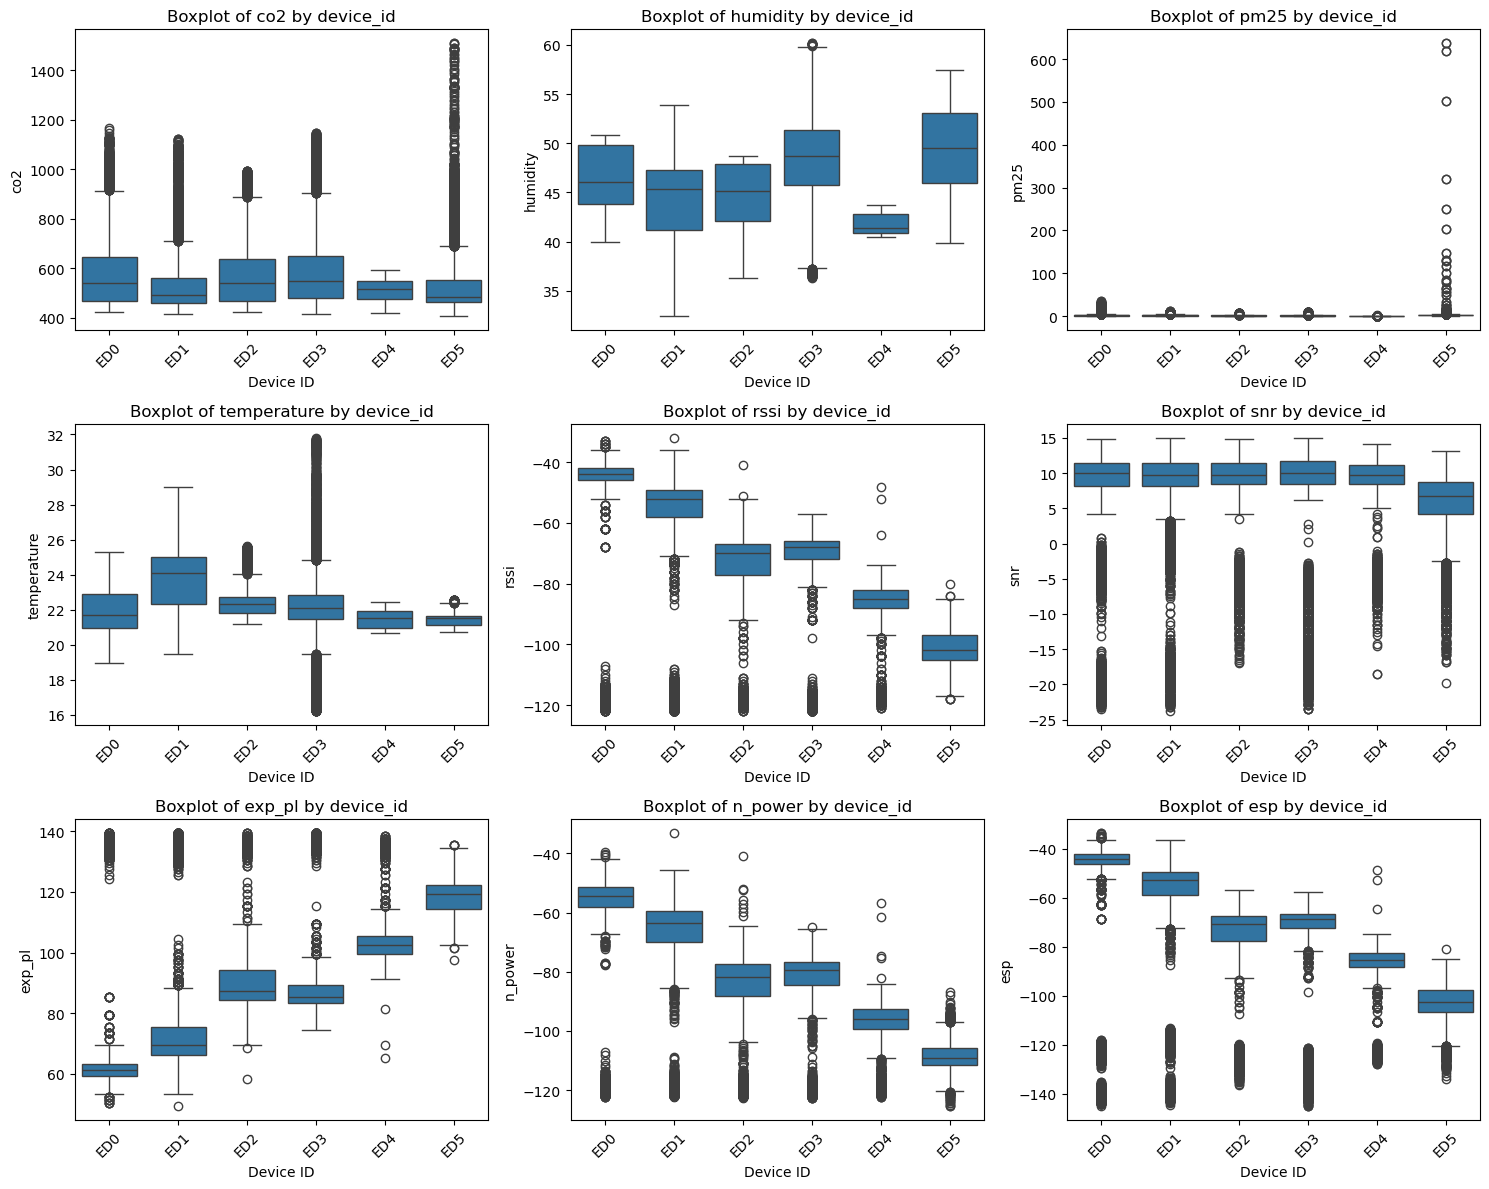

In [13]:
# Columns to exclude
exclude_cols = ['f_count', 'p_count', 'c_walls', 'w_walls', 'frequency', 'SF', 'toa', 'distance', 'pressure']

# Select numeric columns excluding 'f_count' and 'p_count'
numeric_cols = cleaned_df.select_dtypes(include=['float64', 'int64']).columns.drop(exclude_cols)

# Define the desired order for device_id
desired_order = ['ED0', 'ED1', 'ED2', 'ED3', 'ED4', 'ED5'] 

# Ensure 'device_id' is a categorical type with the specified order
cleaned_df['device_id'] = pd.Categorical(cleaned_df['device_id'], categories=desired_order, ordered=True)

# Determine the number of plots
num_vars = len(numeric_cols)
cols = 3  # Number of columns in the subplot grid
rows = math.ceil(num_vars / cols)

# Set the overall figure size
plt.figure(figsize=(cols * 5, rows * 4))

# Iterate over each numeric column and create a subplot
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.boxplot(x='device_id', y=col, data=cleaned_df, order=desired_order)
    plt.title(f'Boxplot of {col} by device_id')
    plt.xlabel('Device ID')
    plt.ylabel(col)
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Visual Dataframe Cleaning
</p>

In [15]:
# Exclude all rows where 'rssi' looks anomalous
# cleaned_df = cleaned_df[cleaned_df['rssi'] > -116]

# Define RSSI thresholds for each device
rssi_thresholds = {
    'ED0': -100.0,
    'ED1': -100.0,
    'ED2': -100.0,
    'ED3': -130.0,
    'ED4': -116.0,
    'ED5': -131.0
}

# Apply the thresholds using the map and filter the DataFrame
#cleaned_df = cleaned_df[cleaned_df['rssi'] > cleaned_df['device_id'].map(rssi_thresholds)]

# Resetting the index after filtering
#cleaned_df.reset_index(drop=True, inplace=True)

# Exclude data points for device ED4
#cleaned_df = cleaned_df[~cleaned_df['device_id'].isin(['ED4'])]

# Exclude SFxx and SF12 datapoints
#cleaned_df = cleaned_df[~cleaned_df['SF'].isin([12])]

# Remove rows with a temperature above 30
#cleaned_df = cleaned_df[~(cleaned_df['temperature'] > 30)]
# Remove rows with humidity below 20
#cleaned_df = cleaned_df[~(cleaned_df['humidity'] < 20)]


# Remove rows with SNR that is negative
#cleaned_df = cleaned_df[~(cleaned_df['snr'] < -3)]

# Save all data to csv
cleaned_df.to_csv('../all_data_files/visually_cleaned_df.csv', index=False)

# Display the cleaned Dataframe Info
print("\nInfo of Combined DataFrame:\n")
cleaned_df.info()

# Display the cleaned Dataframe Head and Tail
print("\nCleaned DataFrame:\n")
cleaned_df



Info of Combined DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81211 entries, 0 to 81210
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   time         81211 non-null  object  
 1   device_id    81211 non-null  category
 2   co2          81211 non-null  float64 
 3   humidity     81211 non-null  float64 
 4   pm25         81211 non-null  float64 
 5   pressure     81211 non-null  float64 
 6   temperature  81211 non-null  float64 
 7   rssi         81211 non-null  float64 
 8   snr          81089 non-null  float64 
 9   SF           81211 non-null  float64 
 10  frequency    81211 non-null  float64 
 11  f_count      81211 non-null  float64 
 12  p_count      81211 non-null  float64 
 13  toa          81211 non-null  float64 
 14  distance     81211 non-null  int64   
 15  c_walls      81211 non-null  int64   
 16  w_walls      81211 non-null  int64   
 17  exp_pl       81211 non-null  float64 
 

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-10-10 13:45:13.254064+02:00,ED3,579.0,47.71,0.46,304.93,26.31,-69.0,9.5,12.0,868.3,18073.0,20280.0,1.810432,18,1,2,86.4,-78.961836,-69.461836
1,2024-10-10 13:45:31.212935+02:00,ED0,581.0,48.94,0.73,304.31,23.45,-46.0,11.2,11.0,867.3,18192.0,20285.0,0.987136,10,0,0,63.4,-57.517549,-46.317549
2,2024-10-10 13:45:47.417424+02:00,ED1,610.0,51.32,0.85,305.38,22.66,-48.0,9.0,12.0,867.7,18044.0,20281.0,1.810432,8,1,0,65.4,-57.514969,-48.514969
3,2024-10-10 13:45:54.623485+02:00,ED2,638.0,47.12,0.43,305.62,24.18,-65.0,9.0,11.0,868.5,18017.0,20288.0,0.987136,25,0,2,82.4,-74.514969,-65.514969
4,2024-10-10 13:45:59.305135+02:00,ED4,502.0,40.78,0.09,306.33,22.35,-79.0,9.0,11.0,867.7,21363.0,24395.0,0.987136,39,0,5,96.4,-88.514969,-79.514969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81206,2024-10-21 10:27:10.193717+02:00,ED0,561.0,50.41,6.56,328.21,22.93,-45.0,9.0,7.0,867.7,32123.0,35906.0,0.071936,10,0,0,62.4,-54.514969,-45.514969
81207,2024-10-21 10:27:23.362353+02:00,ED3,658.0,53.95,2.26,328.83,23.06,-61.0,10.8,8.0,867.7,32055.0,35901.0,0.133632,18,1,2,78.4,-72.146992,-61.346992
81208,2024-10-21 10:27:24.199344+02:00,ED1,592.0,52.56,2.41,329.18,24.23,-51.0,11.5,8.0,867.7,32117.0,35903.0,0.133632,8,1,0,68.4,-62.797062,-51.297062
81209,2024-10-21 10:27:37.137231+02:00,ED2,573.0,48.47,1.28,329.60,22.45,-68.0,8.5,7.0,867.5,31979.0,35908.0,0.071936,25,0,2,85.4,-77.073822,-68.573822


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Plot for Some Dataframe variables over time
</p>

In [17]:
def plot_sensor_readings(cleaned_df, row_map):
    """
    Plots sensor readings by grouping devices and assigning colors dynamically.
    Ensures the plot is fully visible in Jupyter notebooks without scrolling.

    Args:
    - cleaned_df (DataFrame): Cleaned DataFrame containing sensor data.
    - row_map (dict): Mapping of sensor parameters to subplot rows.
    """
    # Create subplots dynamically based on the row_map provided
    fig = make_subplots(
        rows=len(row_map), cols=1, 
        subplot_titles=[f'{param.title()} Readings Over Time' for param in row_map]
    )

    # Define a pool of colors and create an iterator to cycle through them
    color_pool = itertools.cycle(['green', 'red', 'blue', 'purple', 'orange', 
                                  'cyan', 'magenta', 'brown', 'black', 'pink'])
    
    # Group by unique device IDs and assign colors dynamically
    device_colors = {device: next(color_pool) for device in cleaned_df['device_id'].unique()}

    # Set to track which devices have already been added to the legend
    devices_in_legend = set()

    # Plotting for each parameter and each device
    for param, row in row_map.items():
        for device, color in device_colors.items():
            # Filter data for the specific device
            data = cleaned_df[cleaned_df['device_id'] == device]
            
            # Add a trace for each parameter for the current device
            fig.add_trace(
                go.Scatter(
                    x=data['time'], 
                    y=data[param], 
                    mode='lines',  # Line plot
                    name=f"{device}" if device not in devices_in_legend else None,  # Add device to legend once
                    line=dict(color=color),
                    showlegend=device not in devices_in_legend  # Only show legend if the device hasn't been added yet
                ),
                row=row, col=1  # Place in the correct subplot
            )

            # Mark the device as added to the legend
            devices_in_legend.add(device)

    # Update layout with fixed height and other settings
    fig.update_layout(
        height=1800,  # Fixed height to accommodate all subplots
        showlegend=True,  # Show legend
        title_text="Sensor Readings Over Time",  # Overall plot title
        legend=dict(title="Devices", x=1.05, y=1)  # Adjust legend position
    )

    # Show the plot
    fig.show()

# Example usage:
# Define the row mapping for parameters; can be modified as needed
row_map = {
    'temperature': 1, 'humidity': 2, 'co2': 3, 'pm25': 4, 
    'pressure': 5, 'rssi': 6, 'snr': 7, 'p_count': 8, 'f_count': 9
}

# Calling the function with the cleaned DataFrame and row_map
#plot_sensor_readings(cleaned_df, row_map)

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold;
color: blue;  text-align: left;">
  Statistical Description
</p>

In [19]:
# Generate the statistical description of the cleaned DataFrame
stat_description = cleaned_df.describe().transpose()

# Set the display format for floating-point numbers to 3 decimal places
pd.options.display.float_format = '{:,.3f}'.format 

# Save the statistical description to an Excel file
excel_path = "statistical_description.xlsx"
stat_description.to_excel(excel_path)

# Display the statistical description
stat_description

,count,mean,std,min,25%,50%,75%,max
co2,"81,211.000",552.285,122.486,407.000,469.000,514.000,590.000,"1,510.000"
humidity,"81,211.000",45.759,4.405,32.430,42.410,45.660,48.890,60.190
pm25,"81,211.000",1.816,5.988,0.000,0.760,1.410,2.250,637.710
pressure,"81,211.000",321.629,3.795,304.310,319.240,321.560,324.740,330.380
temperature,"81,211.000",22.215,1.705,16.200,21.290,21.840,22.740,31.800
rssi,"81,211.000",-76.288,24.076,-122.000,-96.000,-72.000,-56.000,-32.000
snr,"81,089.000",7.534,6.593,-23.800,7.500,9.500,11.200,15.000
SF,"81,211.000",9.328,1.686,7.000,8.000,9.000,11.000,12.000
frequency,"81,211.000",867.832,0.460,867.100,867.500,867.900,868.300,868.500
f_count,"81,211.000","26,773.719","4,334.889","18,017.000","23,613.500","26,795.000","30,044.500","36,719.000"


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold;
color: blue;  text-align: left;">
  Correlation Matrix and the HeatMap
</p>

In [21]:
# Select only the numeric columns
numeric_df = cleaned_df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Set the display format for floating-point numbers to xx decimal places
pd.options.display.float_format = '{:,.3f}'.format 

# Display the Correlation Matrix
correlation_matrix

,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
co2,1.000,-0.036,0.124,-0.111,0.308,0.076,0.020,-0.003,-0.004,-0.254,-0.257,-0.002,-0.132,-0.037,-0.109,-0.076,0.075,0.067
humidity,-0.036,1.000,0.074,-0.182,-0.396,-0.060,-0.078,0.001,0.002,0.276,0.242,-0.001,0.048,0.406,-0.207,0.060,-0.049,-0.060
pm25,0.124,0.074,1.000,-0.066,0.052,0.010,-0.010,-0.006,-0.001,0.010,-0.000,-0.007,-0.034,0.100,-0.111,-0.010,0.014,0.009
pressure,-0.111,-0.182,-0.066,1.000,-0.038,-0.043,0.001,-0.000,-0.006,0.398,0.410,-0.001,0.087,-0.060,0.145,0.043,-0.047,-0.039
temperature,0.308,-0.396,0.052,-0.038,1.000,0.179,0.043,0.001,-0.005,-0.058,-0.051,0.000,-0.364,0.014,-0.303,-0.179,0.189,0.168
rssi,0.076,-0.060,0.010,-0.043,0.179,1.000,0.668,-0.274,-0.003,-0.237,-0.218,-0.344,-0.628,-0.330,-0.458,-1.000,0.993,0.994
snr,0.020,-0.078,-0.010,0.001,0.043,0.668,1.000,-0.365,-0.066,-0.063,-0.054,-0.489,-0.038,-0.115,0.029,-0.668,0.587,0.740
SF,-0.003,0.001,-0.006,-0.000,0.001,-0.274,-0.365,1.000,0.077,0.001,0.000,0.907,0.002,0.002,-0.000,0.274,-0.249,-0.299
frequency,-0.004,0.002,-0.001,-0.006,-0.005,-0.003,-0.066,0.077,1.000,0.005,0.004,0.082,0.009,0.009,0.001,0.003,0.012,-0.006
f_count,-0.254,0.276,0.010,0.398,-0.058,-0.237,-0.063,0.001,0.005,1.000,0.997,-0.002,0.390,0.195,0.256,0.237,-0.240,-0.215


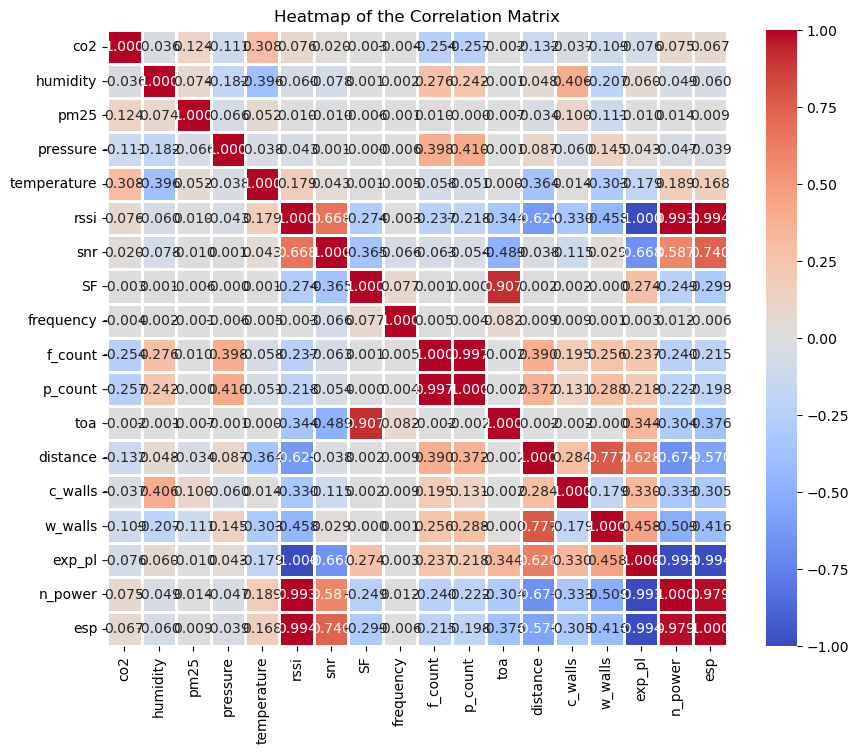

In [22]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.8)
plt.title('Heatmap of the Correlation Matrix')
plt.show()

In [23]:
#Single out RSSI and sort the values
numeric_df.corr()['rssi'].sort_values()

exp_pl        -1.000
distance      -0.628
w_walls       -0.458
toa           -0.344
c_walls       -0.330
SF            -0.274
f_count       -0.237
p_count       -0.218
humidity      -0.060
pressure      -0.043
frequency     -0.003
pm25           0.010
co2            0.076
temperature    0.179
snr            0.668
n_power        0.993
esp            0.994
rssi           1.000
Name: rssi, dtype: float64

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Scatter Plots : SNR vs RSSI for each Devices
</p>

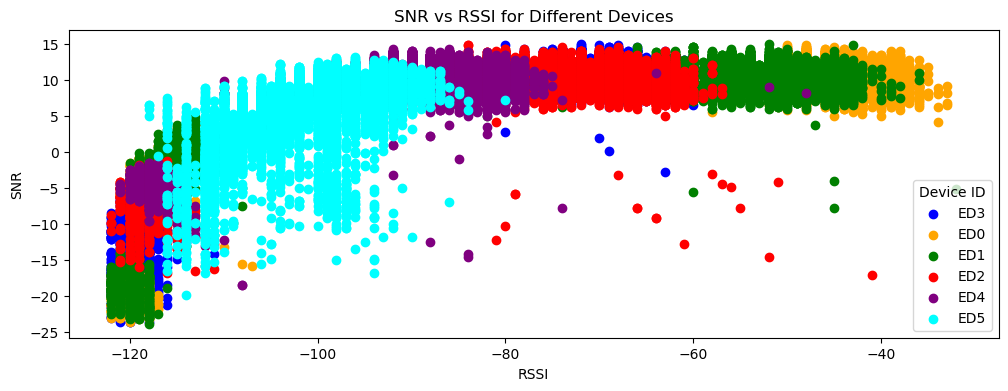

In [25]:
def plot_snr_vs_rssi(cleaned_df):
    """
    Plots SNR vs RSSI for each device dynamically using different colors.

    Args:
    - cleaned_df (DataFrame): Cleaned DataFrame containing sensor data with 'rssi' and 'snr' columns.
    """
    # Define a pool of colors and create an iterator to cycle through them
    color_pool = itertools.cycle(['blue', 'orange', 'green', 'red', 'purple', 
                                  'cyan', 'magenta', 'brown', 'black', 'pink'])

    # Create a figure for plotting
    plt.figure(figsize=(12, 4))

    # Group by unique device IDs and assign colors dynamically
    for device, color in zip(cleaned_df['device_id'].unique(), color_pool):
        # Filter data for each device
        subset = cleaned_df[cleaned_df['device_id'] == device]
        # Scatter plot for SNR vs RSSI
        plt.scatter(subset['rssi'], subset['snr'], label=device, color=color)

    # Add labels, legend, and title
    plt.xlabel('RSSI')
    plt.ylabel('SNR')
    plt.legend(title='Device ID')
    plt.title('SNR vs RSSI for Different Devices')

    # Show the plot
    plt.show()

# Example usage:
plot_snr_vs_rssi(cleaned_df)


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Exploration of LoRAWAN Parameters based on the Spreading Factor
</p>

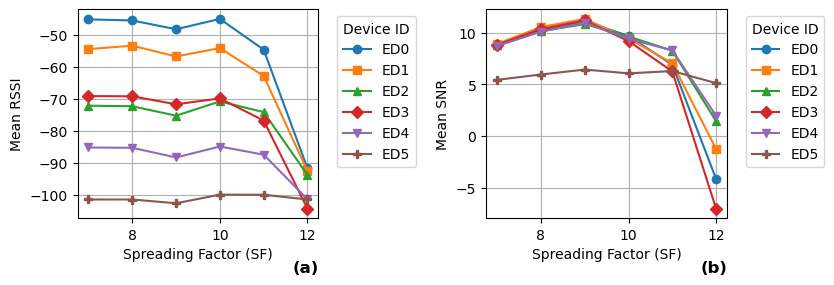

In [27]:
def plot_mean_metric(ax, cleaned_df, metric, ylabel, label=''):
    """
    Plots the mean of a specified metric grouped by Spreading Factor (SF) for each device.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - cleaned_df (DataFrame): DataFrame containing sensor data with 'device_id', 'SF', and metric columns.
    - metric (str): The metric to plot (e.g., 'rssi', 'snr', 'toa').
    - ylabel (str): The label for the y-axis.
    - label (str): The subplot label (e.g., '(a)')
    """
    # Define a pool of markers to use for different devices
    marker_pool = itertools.cycle(['o', 's', '^', 'D', 'v', 'P', '*'])
    
    # Group by device and calculate mean metric for each SF
    for device_id, device_data in cleaned_df.groupby('device_id', observed=False):
        mean_metric = device_data.groupby('SF', observed=False)[metric].mean()
        # Plot mean metric for each device with a different marker
        ax.plot(mean_metric.index, mean_metric.values, marker=next(marker_pool), linestyle='-', label=device_id)
    
    # Set labels
    ax.set_xlabel('Spreading Factor (SF)')
    ax.set_ylabel(ylabel)
    # Title is deactivated as per user request
    # ax.set_title(title)
    ax.grid(True)
    
    # Sort the legend entries alphabetically
    handles, labels_ = ax.get_legend_handles_labels()
    sorted_pairs = sorted(zip(labels_, handles), key=lambda x: x[0])
    sorted_labels, sorted_handles = zip(*sorted_pairs)
    
    # Create a separate legend for each subplot, placed outside the plot
    ax.legend(sorted_handles, sorted_labels, title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add itemize label (e.g., '(a)') to the subplot
    ax.text(1, -0.2, label, transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

# Assuming 'cleaned_df' is your DataFrame and is already defined
# Example:
# cleaned_df = pd.read_csv('your_data.csv')

# Set up the matplotlib figure with subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  # Increased figsize for better layout

# Define subplot labels
subplot_labels = ['(a)', '(b)']

# Plot mean RSSI
plot_mean_metric(axes[0], cleaned_df, 'rssi', 'Mean RSSI', label=subplot_labels[0])

# Plot mean SNR
plot_mean_metric(axes[1], cleaned_df, 'snr', 'Mean SNR', label=subplot_labels[1])

# Adjust layout to make space for the legends
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for legends

# Save the figure 
plt.savefig('../all_data_files/rssi_and_snr_per_SF.png', dpi=800, bbox_inches='tight')

# Show the plot
plt.show()


In [28]:
# Calculate the mean of rssi, snr and exp_pl grouped by device_id
mean_values = cleaned_df.groupby('device_id', observed=False)[['rssi', 'snr', 'exp_pl']].mean()

# Display the mean values
mean_values

,rssi,snr,exp_pl
device_id,,,
ED0,-53.932,7.483,71.332
ED1,-61.412,8.024,78.812
ED2,-76.036,8.408,93.436
ED3,-75.955,6.951,93.355
ED4,-88.468,8.458,105.868
ED5,-101.257,5.907,118.657


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 KDE Plots: Environmental Parameters & LoRaWAN Signal PARAMETERS
</p>

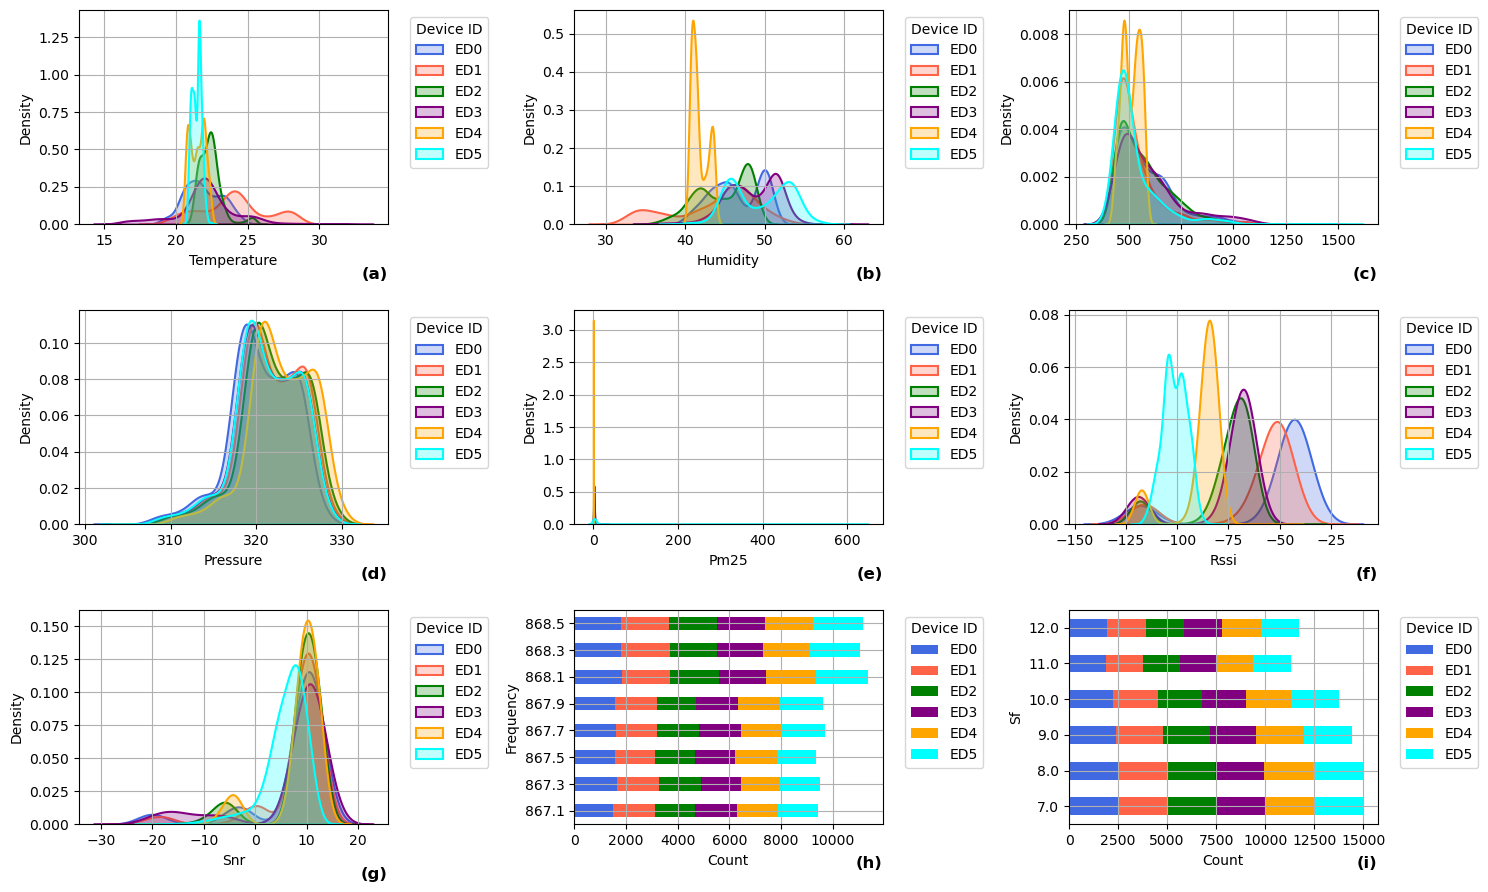

In [30]:
def plot_stacked_bar(ax, data, parameter, label=''):
    """
    Plots a stacked bar chart for the given parameter, grouping by 'device_id'.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - data (DataFrame): DataFrame containing sensor data with 'device_id' and the parameter to plot.
    - parameter (str): The parameter to plot (e.g., 'frequency', 'SF', 'distance').
    - label (str): The subplot label (e.g., '(a)')
    """
    # Define a pool of colors to use for different devices
    color_pool = itertools.cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta'])
    
    # Pivot the data to have device_id as columns
    pivot_data = data.pivot_table(index=parameter, columns='device_id', aggfunc='size', fill_value=0, observed=False)
    
    # Sort device_ids alphabetically
    device_ids = sorted(pivot_data.columns)
    
    # Create a color map dynamically based on sorted device_ids
    colors = {device: next(color_pool) for device in device_ids}

    # Plot the stacked bar plot
    pivot_data[device_ids].plot(kind='barh', stacked=True, ax=ax, color=[colors[device] for device in device_ids])
    
    # Disable the subplot title
    # ax.set_title(title)
    
    ax.set_xlabel('Count')
    ax.set_ylabel(parameter.capitalize())
    ax.grid(True)
    
    # Sort the legend entries alphabetically
    handles, labels_ = ax.get_legend_handles_labels()
    sorted_pairs = sorted(zip(labels_, handles), key=lambda x: x[0])
    sorted_labels, sorted_handles = zip(*sorted_pairs)
    ax.legend(sorted_handles, sorted_labels, title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add itemize label below x-axis label
    ax.text(1, -0.15, label, transform=ax.transAxes, ha='right', va='top', fontweight='bold', fontsize=12)

def plot_kde(ax, data, parameter, bw_adjust=2, label=''):
    """
    Plots a Kernel Density Estimate (KDE) for the given parameter, grouped by 'device_id'.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - data (DataFrame): DataFrame containing sensor data with 'device_id' and the parameter to plot.
    - parameter (str): The parameter to plot (e.g., 'temperature', 'humidity', 'co2').
    - bw_adjust (float): Bandwidth adjustment for the KDE plot.
    - label (str): The subplot label (e.g., '(a)')
    """
    # Define a pool of colours to use for different devices
    color_pool = itertools.cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta'])
    
    # Get sorted device_ids
    device_ids = sorted(data['device_id'].unique())
    
    # Create a color map dynamically based on sorted device_ids
    colors = {device_id: next(color_pool) for device_id in device_ids}
    
    # Plot KDE for each device, sorted by device_id
    for device_id in device_ids:
        subset = data[data['device_id'] == device_id]
        sns.kdeplot(
            subset[parameter], ax=ax, 
            label=device_id, 
            lw=1.5, 
            bw_adjust=bw_adjust, 
            fill=True, 
            color=colors[device_id]
        )
    
    # Disable the subplot title
    # ax.set_title(title)
    
    ax.set_xlabel(parameter.capitalize())
    ax.set_ylabel('Density')
    ax.grid(True)
    
    # Sort the legend entries alphabetically
    handles, labels_ = ax.get_legend_handles_labels()
    sorted_pairs = sorted(zip(labels_, handles), key=lambda x: x[0])
    sorted_labels, sorted_handles = zip(*sorted_pairs)
    ax.legend(sorted_handles, sorted_labels, title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add itemize label below x-axis label
    ax.text(1, -0.2, label, transform=ax.transAxes, ha='right', va='top', fontweight='bold', fontsize=12)

# Filter the DataFrame
filtered_df = cleaned_df[cleaned_df['device_id'].isin(cleaned_df['device_id'].unique())]

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 9))  # Increased figure height for better spacing

# Define subplot labels
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

# Plot each parameter on a separate subplot with corresponding labels
plot_kde(axes[0, 0], filtered_df, 'temperature', bw_adjust=2, label=subplot_labels[0])
plot_kde(axes[0, 1], filtered_df, 'humidity', bw_adjust=2, label=subplot_labels[1])
plot_kde(axes[0, 2], filtered_df, 'co2', bw_adjust=2, label=subplot_labels[2])
plot_kde(axes[1, 0], filtered_df, 'pressure', bw_adjust=2, label=subplot_labels[3])
plot_kde(axes[1, 1], filtered_df, 'pm25', bw_adjust=2, label=subplot_labels[4])
plot_kde(axes[1, 2], filtered_df, 'rssi', bw_adjust=2, label=subplot_labels[5])
plot_kde(axes[2, 0], filtered_df, 'snr', bw_adjust=2, label=subplot_labels[6])

# Plot the stacked bar charts on the last two subplots with corresponding labels
plot_stacked_bar(axes[2, 1], filtered_df, 'frequency', label=subplot_labels[7])
plot_stacked_bar(axes[2, 2], filtered_df, 'SF', label=subplot_labels[8])

# Ensure proper spacing between rows by adjusting the layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  #space between rows

# Save the figure
plt.savefig('../all_data_files/signal_environmental_dist.png', dpi=800, bbox_inches='tight')

# Show the plot
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 LoRaWAN Effective Signal Power vs Noise Power
</p>

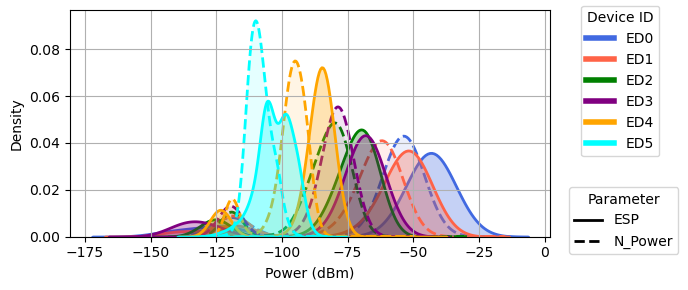

In [32]:
def plot_esp_n_power_comparison(ax, data, bw_adjust=2, title='ESP vs N_Power Distribution per Device'):
    """
    Compare 'esp' and 'n_power' distributions per device using KDE plots.
    'ESP' is dashed and 'N_Power' is solid.
    """
    # Assign colors to each device
    color_pool = cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'olive', 'pink'])
    devices = sorted(data['device_id'].unique())
    colors = {device: next(color_pool) for device in devices}
    
    for device in devices:
        subset = data[data['device_id'] == device]
        # Plot 'ESP' with solid line
        sns.kdeplot(
            subset['esp'], ax=ax, label=f'{device} - ESP', lw=2, bw_adjust=bw_adjust,
            linestyle='-', color=colors[device], fill=True, alpha=0.3
        )
        # Plot 'N_Power' with dashed line
        sns.kdeplot(
            subset['n_power'], ax=ax, label=f'{device} - N_Power', lw=2, bw_adjust=bw_adjust,
            linestyle='--', color=colors[device], fill=True, alpha=0.1
        )
    
    # Set titles and labels
   #  ax.set_title(title)
    ax.set_xlabel('Power (dBm)')
    ax.set_ylabel('Density')
    ax.grid(True)
    
    # Create legends
    device_handles = [Line2D([0], [0], color=colors[device], lw=4) for device in devices]
    device_labels = devices
    parameter_handles = [
        Line2D([0], [0], color='black', lw=2, linestyle='-'),
        Line2D([0], [0], color='black', lw=2, linestyle='--')
    ]
    parameter_labels = ['ESP', 'N_Power']
    
    # Add device legend
    legend1 = ax.legend(device_handles, device_labels, title='Device ID',
                        bbox_to_anchor=(1.05, 1.05), loc='upper left')
    # Add parameter legend
    legend2 = ax.legend(parameter_handles, parameter_labels, title='Parameter',
                        bbox_to_anchor=(1.025, 0.25), loc='upper left')
    ax.add_artist(legend1)

# Plotting the comparison
fig, ax = plt.subplots(figsize=(7, 3))
plot_esp_n_power_comparison(ax, filtered_df, bw_adjust=2, title='ESP vs N_Power Distribution per Device')
plt.tight_layout()

# Save the plot
plt.savefig('../all_data_files/esp_n_power_comparison.png', dpi=800)

# Display the plot
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 PLM Modelling and Comaprison
</p>



 Multi-Wall Model Fitting
Total number of rows: 69481
Rows with NaN or Inf: 89 (0.13%)
Rows after cleaning: 69392 (99.87%)

=== Table of Parameters to be Compared ===



,Parameter,LDPLM - MW,LDPLM - MW - EP
0,PL(d0) [dB],18.342,30.683
1,Path loss exponent (n),4.823,4.228
2,Brick Wall Loss (L_c) [dB],9.040,7.426
3,Wood Wall Loss (L_w) [dB],1.625,2.247
4,CO2 coefficient (a_co2) [dB/unit],-,-0.001
5,Humidity coefficient (a_hum) [dB/unit],-,-0.347
6,PM2.5 coefficient (a_pm25) [dB/unit],-,-0.003
7,Pressure coefficient (a_pres) [dB/unit],-,-0.125
8,Temperature coefficient (a_temp) [dB/unit],-,0.548
9,SNR scaling factor (k_snr),-,2.132



=== Performance Metrics Comparison ===



,LDPLM - MW,LDPLM - MW - EP
RMSE (dB),12.925,8.551
R-squared,0.655,0.849
Shadowing σ (dB),12.598,8.348


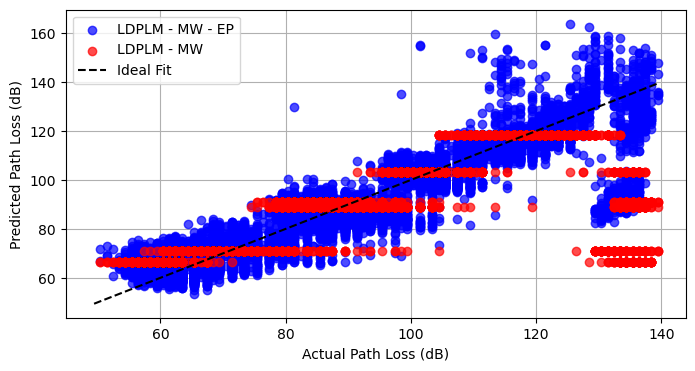

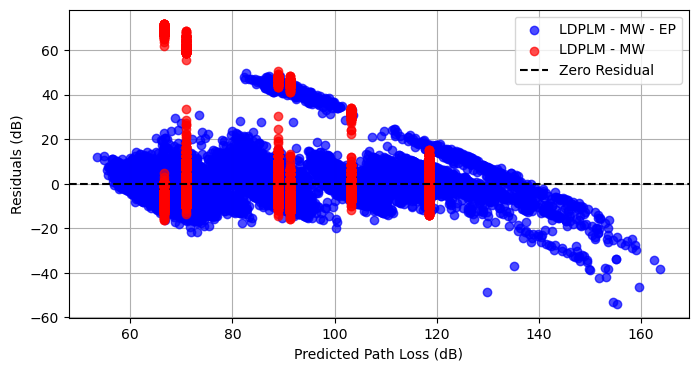

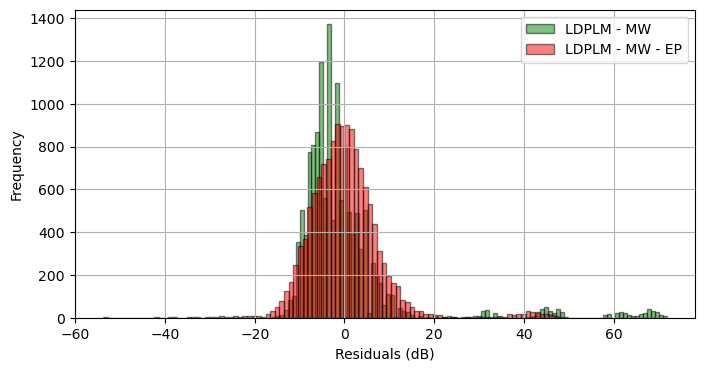


Residual Distribution Values:

LDPLM - MW: Mean:0.0926 dB, Skewness: 3.5806 dB
LDPLM - MW - EP: Mean:0.0655 dB, Skewness: 1.6417 dB

=== Cross-Validation (5-Fold) ===

Fold 1: 
LDPLM - MW RMSE = 12.93 dB, R-squared = 0.6549;
LDPLM - MW - EP RMSE = 8.55 dB, R-squared = 0.8490 

Fold 2: 
LDPLM - MW RMSE = 12.98 dB, R-squared = 0.6510;
LDPLM - MW - EP RMSE = 8.65 dB, R-squared = 0.8449 

Fold 3: 
LDPLM - MW RMSE = 12.53 dB, R-squared = 0.6746;
LDPLM - MW - EP RMSE = 8.24 dB, R-squared = 0.8594 

Fold 4: 
LDPLM - MW RMSE = 12.48 dB, R-squared = 0.6707;
LDPLM - MW - EP RMSE = 8.20 dB, R-squared = 0.8581 

Fold 5: 
LDPLM - MW RMSE = 12.39 dB, R-squared = 0.6727;
LDPLM - MW - EP RMSE = 8.31 dB, R-squared = 0.8529 


Average RMSE across folds:
LDPLM - MW: 12.66 dB
LDPLM - MW - EP: 8.39 dB

Average R-squared across folds:
LDPLM - MW: 0.6648
LDPLM - MW - EP: 0.8529


In [34]:
# Run the two Fitting Models [Multi-wall & the Enhanced] NoteBook and Check Results here

print('\n\n Multi-Wall Model Fitting')
%run "LDPLM - BOTH.ipynb"
